<hr style="height:3pt">

# Fisher Scoring Demo for Advanced Section 3: GLM's

### Kevin Rader (special thanks to Nick Stern) | AC209a | October 14, 2020

<hr style="height:3pt">

The following code implements the Fisher Scoring algorithm to solve for the optimal parameters in a simple logistic regression. The data we are using are the O-ring measurements that were taken leading up to the Challenger disaster in 1986. The space shuttle burned up on the launch pad because one of the O-rings failed due to the cold temperatures. We're going to regress temperature on O-ring failure to see if we can find a correlation.

The data were obtained [here](https://gist.github.com/jtrive84/835514a76f7afd552c999e4d9134baa8).

This example is originally found [here](http://www.jtrive.com/estimating-logistic-regression-coefficents-from-scratch-python-version.html).

In [1]:
## Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from IPython import display
import seaborn as sns
sns.set(style='white')

In [2]:
## Implementation of Fisher Scoring algorithm for simple logistic regression
df = pd.read_csv('data/Challenger.csv')
df['INTERCEPT'] = 1
print(df.shape)
df.head()

(23, 5)


,FLIGHT,TEMPERATURE,PRESSURE,O_RING_FAILURE,INTERCEPT
0,1,66,50,0,1
1,2,70,50,1,1
2,3,69,50,0,1
3,4,68,50,0,1
4,5,67,50,0,1


In [3]:
## Setup X and y
X = df[['INTERCEPT', 'TEMPERATURE']].values
y = df['O_RING_FAILURE'].values

In [4]:
def fisher_scoring(design_matrix, response_vector, epsilon=.001):
    """
    Determine Logistic Regression coefficents using Fisher Scoring algorithm.
    Iteration ceases once changes between elements in coefficent matrix across
    consecutive iterations is less than epsilon.
    # =========================================================================
    # design_matrix      `X`     => n-by-(p+1)                                |
    # response_vector    `y`     => n-by-1                                    |
    # probability_vector `p`     => n-by-1                                    |
    # weights_matrix     `W`     => n-by-n                                    |
    # epsilon                    => threshold above which iteration continues |
    # =========================================================================
    # n                          => # of observations                         |
    # (p + 1)                    => # of parameterss, +1 for intercept term   |
    # =========================================================================
    # U => First derivative of Log-Likelihood with respect to                 |
    #      each beta_i, i.e. `Score Function`: X_transpose * (y - p)          |
    #                                                                         |
    # I => Second derivative of Log-Likelihood with respect to                |
    #      each beta_i. The `Information Matrix`: (X_transpose * W * X)       |
    #                                                                         |
    # X^T*W*X results in a (p+1)-by-(p+1) matrix                              |
    # X^T(y - p) results in a (p+1)-by-1 matrix                               |
    # (X^T*W*X)^-1 * X^T(y - p) results in a (p+1)-by-1 matrix                |
    # ========================================================================|
    """
    X = np.matrix(design_matrix)
    y = np.matrix(response_vector).T

    # initialize logistic function used for Scoring calculations =>
    def pi_i(v): return (np.exp(v) / (1 + np.exp(v)))

    # initialize beta_0, p_0, W_0, I_0 & U_0 =>
    beta_0 = np.matrix(np.zeros(X.shape[1])).T
    p_0 = pi_i(X @ beta_0)
    W_pre = (np.array(p_0) * np.array(1 - p_0))
    W_0 = np.matrix(np.diag(W_pre[:, 0]))
    I_0 = X.T @ W_0 @ X
    U_0 = X.T @ (y - p_0)

    # initialize variables for iteration =>
    beta_old = beta_0
    iter_I = I_0
    iter_U = U_0
    iter_p = p_0
    iter_W = W_0
    fisher_scoring_iterations = 0
    
    # iterate until abs(beta_new - beta_old) < epsilon =>
    coeffs = [np.array(beta_old).flatten()]
    while True:
        # Fisher Scoring Update Step =>
        fisher_scoring_iterations += 1
        beta_new = beta_old + iter_I.I * iter_U
        coeffs.append(np.array(beta_new).flatten())
        
        if np.all(np.abs(np.array(beta_new)-np.array(beta_old)) < epsilon):
            break

        else:
            iter_p     = pi_i(X * beta_new)
            iter_W_pre = (np.array(iter_p) * np.array(1 - iter_p))
            iter_W     = np.matrix(np.diag(iter_W_pre[:, 0]))
            iter_I     = X.T * iter_W * X
            iter_U     = X.T * (y - iter_p)
            beta_old   = beta_new

    return coeffs

In [5]:
betas = fisher_scoring(X, y)

In [6]:
def log_likelihood(X, y, betas):
    '''
    Calculates log-likelihood for logistic regression
    Input shapes:
        X - n x (p + 1)
        y - n x 1
        betas - (p + 1) x 1
    '''
    return np.sum(y*np.log(np.exp(X @ betas)/(1+np.exp(X @ betas))) + (1 - y)*np.log(1/(1+np.exp(X @ betas))))

In [7]:
def animate():
    '''
    Animates parameter estimate convergence
    '''
    b1s = [x[1] for x in betas]
    xs = np.linspace(np.min(b1s)-.2, np.max(b1s), 100)
    ys = [log_likelihood(X, y, [betas[-1][0], b]) for b in xs]
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(xs, ys)
    for i, b in enumerate(b1s):
        ax.scatter(b, log_likelihood(X, y, [betas[-1][0], b]), c='r')
        ax.plot([b]*100, np.linspace(np.min(ys), log_likelihood(X, y, [betas[-1][0], b]), 100), 'r--')
        ax.set_ylabel('Log-Likelihood', fontsize=15)
        ax.set_xlabel('beta1', fontsize=15)
        ax.set_title(f'Fisher Scoring Algorithm: Iteration {i+1}', fontsize=20)
        display.clear_output(wait=True)
        display.display(fig)
        time.sleep(.4)
    display.clear_output(wait=True)

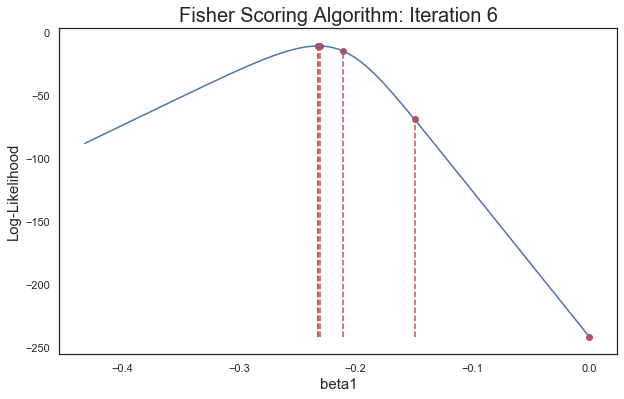

In [8]:
animate()